# Análisis de resultados

- Autor: Lucía Cordero Sánchez
- Máster en Inteligencia Artificial Aplicada – UC3M
- Asignatura: Computación Evolutiva

## Introducción
El objetivo es entender cómo los parámetros evolutivos (población, mutación, elitismo, penalización, etc.) afectan al rendimiento del optimizador evolutivo y justificar las decisiones de diseño adoptadas.

## Configuración inicial e importación de datasets

In [ ]:
import os
import json
import time
import warnings
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from evopt import EvolutionaryOptimizer

warnings.filterwarnings("ignore")

RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

DATASETS = {
    "California": "data/california.csv",
    "Diabetes": "data/diabetes.csv"
}

MAXTIME = 180           # Tiempo máximo del optimizador por ejecución (segundos)
TEST_SIZE = 0.25        # Porcentaje de validación
RANDOM_STATE = 42

## Definición de modelos

In [2]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import HuberRegressor


MODELOS = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=RANDOM_STATE),
    "Lasso": Lasso(alpha=0.001, random_state=RANDOM_STATE, max_iter=2000),
    "ElasticNet": ElasticNet(alpha=0.001, random_state=RANDOM_STATE, max_iter=2000),
    "BayesianRidge": BayesianRidge(),
    "DecisionTree": DecisionTreeRegressor(random_state=RANDOM_STATE),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=RANDOM_STATE),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=RANDOM_STATE),
    "SVR": SVR(),
    "MLP": MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=RANDOM_STATE),
    "KNeighbors": KNeighborsRegressor(n_neighbors=5),
    "Huber": HuberRegressor(max_iter=2000)


}

print(f"🧠 Se evaluarán {len(MODELOS)} modelos en cada escenario.")


🧠 Se evaluarán 14 modelos en cada escenario.


## Definición de los escenarios evolutivos

In [10]:
CONFIGURACIONES = [
    # 🧩 Balance clásico entre exploración y explotación
    {"name": "EquilibrioAdaptativo", "pop_size": 25, "crossover_prob": 0.7, "mutation_prob": 0.35, "elitism": True,
     "complexity_penalty": 0.001, "patience": 30},

    # 🌱 Mayor diversidad con población grande y mutación elevada
    {"name": "DiversidadDirigida", "pop_size": 50, "crossover_prob": 0.75, "mutation_prob": 0.55, "elitism": True,
     "complexity_penalty": 0.001, "patience": 40},

    # 🧬 Evaluar el impacto del elitismo desactivado
    {"name": "SinElitismo", "pop_size": 25, "crossover_prob": 0.7, "mutation_prob": 0.35, "elitism": False,
     "complexity_penalty": 0.001, "patience": 30},

    # ⚡ Mutación muy alta para explorar regiones no lineales del espacio
    {"name": "MutacionAlta", "pop_size": 25, "crossover_prob": 0.65, "mutation_prob": 0.6, "elitism": True,
     "complexity_penalty": 0.001, "patience": 30},

    # ⚖️ Fuerte penalización para evaluar regularización en la complejidad de los individuos
    {"name": "PenalizacionFuerte", "pop_size": 25, "crossover_prob": 0.7, "mutation_prob": 0.35, "elitism": True,
     "complexity_penalty": 0.005, "patience": 30},

    # 🧪 Población muy pequeña: evolución rápida pero riesgo de óptimos locales
    {"name": "PoblacionPequena", "pop_size": 10, "crossover_prob": 0.6, "mutation_prob": 0.35, "elitism": True,
     "complexity_penalty": 0.001, "patience": 30},

    # 🔁 Microevolución prolongada: pequeñas poblaciones con paciencia alta
    {"name": "MicroEvolucion", "pop_size": 12, "crossover_prob": 0.65, "mutation_prob": 0.3, "elitism": True,
     "complexity_penalty": 0.001, "patience": 60},

    # 🧠 Escenario experimental: cruce alto + mutación media → recombinación intensa
    {"name": "CruceAltoMutacionMedia", "pop_size": 30, "crossover_prob": 0.85, "mutation_prob": 0.4, "elitism": True,
     "complexity_penalty": 0.001, "patience": 35},

    # 🚀 Exploración extrema: cruce bajo, mutación alta y sin elitismo
    {"name": "ExploracionExtrema", "pop_size": 40, "crossover_prob": 0.5, "mutation_prob": 0.65, "elitism": False,
     "complexity_penalty": 0.001, "patience": 40}
]

print(f"🧪 Se evaluarán {len(CONFIGURACIONES)} escenarios evolutivos en total.")



🧪 Se evaluarán 9 escenarios evolutivos en total.


## Funciones auxiliares

In [11]:
def evaluar_modelo(modelo, X_train, X_val, y_train, y_val):
    m = clone(modelo)
    m.fit(X_train, y_train)
    y_pred = m.predict(X_val)
    return mean_squared_error(y_val, y_pred)


def evaluar_configuracion(cfg_name, evo_params, dataset_name, path_csv):
    print("\n" + "="*90)
    print(f"🧩 Escenario: {cfg_name} | Dataset: {dataset_name}")
    print("="*90)
    print(f"🔧 Parámetros evolutivos → {evo_params}")

    df = pd.read_csv(path_csv)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    print("\n🚀 Iniciando optimización evolutiva...")
    opt = EvolutionaryOptimizer(maxtime=MAXTIME, **{k: v for k, v in evo_params.items() if k != 'name'})
    start = time.time()
    opt.fit(X_train, y_train)
    elapsed = time.time() - start
    print(f"✅ Finalizado en {elapsed:.1f} segundos | Fitness óptimo: {opt.best_fit:.4f}")

    X_train_opt = opt.transform(X_train)
    X_val_opt = opt.transform(X_val)
    print(f"✨ Conjunto de entrenamiento ampliado a {X_train_opt.shape[1]} variables tras la evolución.")
    print("-"*70)

    resultados = []
    for i, (nombre, modelo) in enumerate(MODELOS.items(), 1):
        try:
            print(f"[{i:02d}/{len(MODELOS)}] 🧠 Evaluando {nombre}...")
            mse_base = evaluar_modelo(modelo, X_train, X_val, y_train, y_val)
            mse_opt = evaluar_modelo(modelo, X_train_opt, X_val_opt, y_train, y_val)
            mejora = 100 * (1 - mse_opt / mse_base)
            tendencia = "⬆️ mejora" if mejora > 0 else "⬇️ empeora"
            print(f"   • MSE base: {mse_base:.4f} | MSE tras evolución: {mse_opt:.4f} | Δ {mejora:+.2f}% {tendencia}")

            resultados.append({
                "config": cfg_name,
                "dataset": dataset_name,
                "modelo": nombre,
                "mse_original": mse_base,
                "mse_optimizado": mse_opt,
                "mejora_%": mejora,
                "tiempo_optimizador_s": elapsed,
                "num_features": X_train_opt.shape[1],
                **evo_params
            })
        except Exception as e:
            print(f"   ⚠️ Error con {nombre}: {e}")
            continue

    mean_improvement = np.mean([r["mejora_%"] for r in resultados]) if resultados else 0
    print("-"*70)
    print(f"🧾 Resumen del escenario {cfg_name}:")
    print(f"   ▫️ Modelos evaluados: {len(resultados)}")
    print(f"   ▫️ Mejora media: {mean_improvement:.2f}%")
    print(f"   ▫️ Tiempo optimizador: {elapsed:.1f}s")
    print(f"   ▫️ Features generadas: {X_train_opt.shape[1]}")
    print("-"*70)

    return resultados


## Ejecución global de experimentos

In [12]:
all_results = []
for cfg in CONFIGURACIONES:
    for dataset_name, path in DATASETS.items():
        res = evaluar_configuracion(cfg["name"], cfg, dataset_name, path)
        all_results.extend(res)


df = pd.DataFrame(all_results)
df.to_csv(os.path.join(RESULTS_DIR, "all_results.csv"), index=False)
print("✅ Resultados globales guardados en results/all_results.csv")
print(f"Total de ejecuciones registradas: {len(df)}")
print(df.groupby(['dataset','config'])['mejora_%'].mean().round(2))


🧩 Escenario: EquilibrioAdaptativo | Dataset: California
🔧 Parámetros evolutivos → {'name': 'EquilibrioAdaptativo', 'pop_size': 25, 'crossover_prob': 0.7, 'mutation_prob': 0.35, 'elitism': True, 'complexity_penalty': 0.001, 'patience': 30}

🚀 Iniciando optimización evolutiva...
[STOP] Early stopping at gen 34
[DONE] Best fitness: -0.41138 | Time: 17.0s
✅ Finalizado en 17.0 segundos | Fitness óptimo: -0.4114
✨ Conjunto de entrenamiento ampliado a 14 variables tras la evolución.
----------------------------------------------------------------------
[01/14] 🧠 Evaluando LinearRegression...
   • MSE base: 0.5411 | MSE tras evolución: 0.4331 | Δ +19.96% ⬆️ mejora
[02/14] 🧠 Evaluando Ridge...
   • MSE base: 0.5410 | MSE tras evolución: 0.4331 | Δ +19.95% ⬆️ mejora
[03/14] 🧠 Evaluando Lasso...
   • MSE base: 0.5394 | MSE tras evolución: 0.4320 | Δ +19.92% ⬆️ mejora
[04/14] 🧠 Evaluando ElasticNet...
   • MSE base: 0.5397 | MSE tras evolución: 0.4324 | Δ +19.88% ⬆️ mejora
[05/14] 🧠 Evaluando Bay

## Análisis de resultados

### Preparación de los datos

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar resultados
df = pd.read_csv(os.path.join(RESULTS_DIR, "all_results.csv"))

# Asegurar tipos correctos
df["elitism"] = df["elitism"].astype(bool)
df["mejora_%"] = df["mejora_%"].astype(float)
df["pop_size"] = df["pop_size"].astype(int)

print(f"Total de ejecuciones: {len(df)}")
display(df.head())


Total de ejecuciones: 252


,config,dataset,modelo,mse_original,mse_optimizado,mejora_%,tiempo_optimizador_s,num_features,name,pop_size,crossover_prob,mutation_prob,elitism,complexity_penalty,patience
0,EquilibrioAdaptativo,California,LinearRegression,0.541129,0.433106,19.962422,16.984649,14,EquilibrioAdaptativo,25,0.7,0.35,True,0.001,30
1,EquilibrioAdaptativo,California,Ridge,0.541047,0.433087,19.953878,16.984649,14,EquilibrioAdaptativo,25,0.7,0.35,True,0.001,30
2,EquilibrioAdaptativo,California,Lasso,0.539428,0.431990,19.917169,16.984649,14,EquilibrioAdaptativo,25,0.7,0.35,True,0.001,30
3,EquilibrioAdaptativo,California,ElasticNet,0.539686,0.432399,19.879501,16.984649,14,EquilibrioAdaptativo,25,0.7,0.35,True,0.001,30
4,EquilibrioAdaptativo,California,BayesianRidge,0.540848,0.433032,19.934620,16.984649,14,EquilibrioAdaptativo,25,0.7,0.35,True,0.001,30


### Distribución general de mejoras

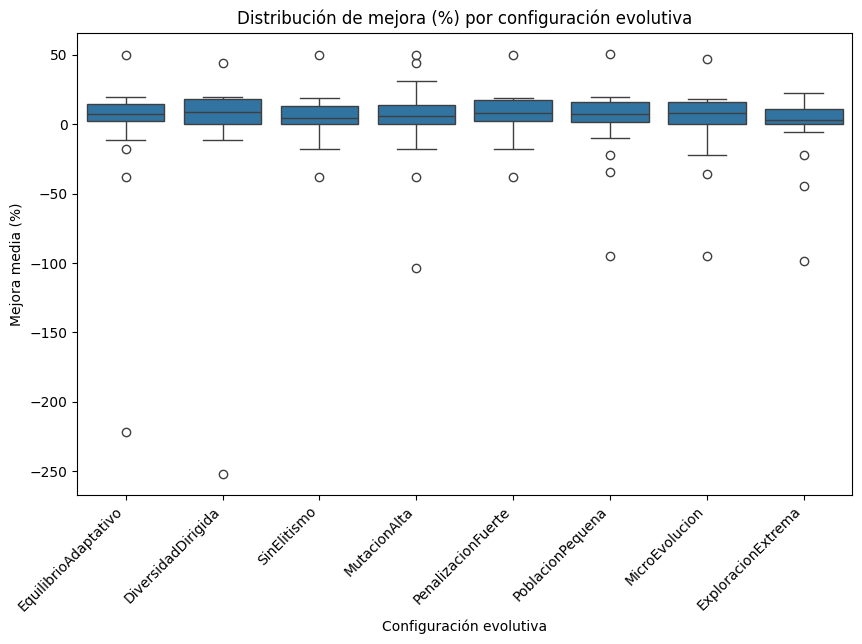

In [19]:
# ---------------------------------------------------------------
# A. Distribución global de mejoras por configuración
# ---------------------------------------------------------------
df_hist_plot = df[df["config"] != "CruceAltoMutacionMedia"]

plt.figure(figsize=(10,6))
sns.boxplot(data=df_hist_plot, x="config", y="mejora_%")
plt.title("Distribución de mejora (%) por configuración evolutiva")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mejora media (%)")
plt.xlabel("Configuración evolutiva")
plt.show()

### Efectos de los parámetros principales

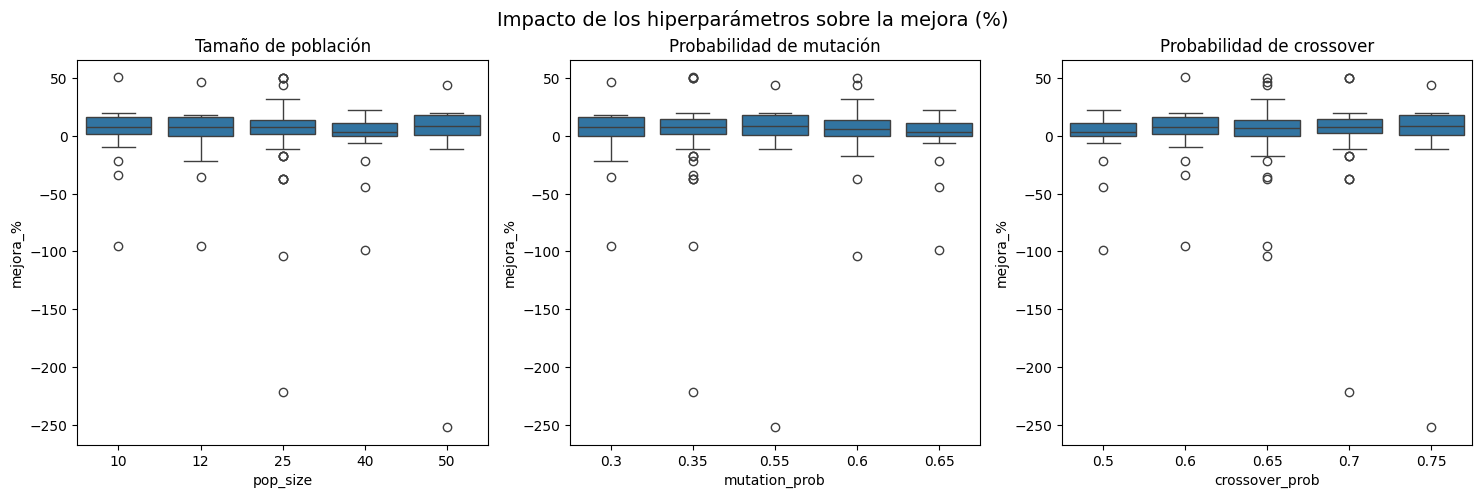

In [21]:
# ---------------------------------------------------------------
# B. Influencia de parámetros clave
# ---------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.boxplot(data=df_hist_plot, x="pop_size", y="mejora_%", ax=axes[0])
axes[0].set_title("Tamaño de población")
axes[0].set_xlabel("pop_size")

sns.boxplot(data=df_hist_plot, x="mutation_prob", y="mejora_%", ax=axes[1])
axes[1].set_title("Probabilidad de mutación")
axes[1].set_xlabel("mutation_prob")

sns.boxplot(data=df_hist_plot, x="crossover_prob", y="mejora_%", ax=axes[2])
axes[2].set_title("Probabilidad de crossover")
axes[2].set_xlabel("crossover_prob")

plt.suptitle("Impacto de los hiperparámetros sobre la mejora (%)", fontsize=14)
plt.show()


### Tiempo vs mejora

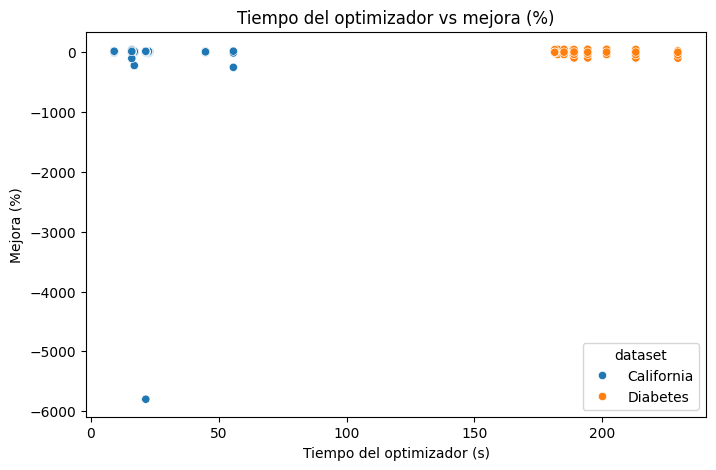

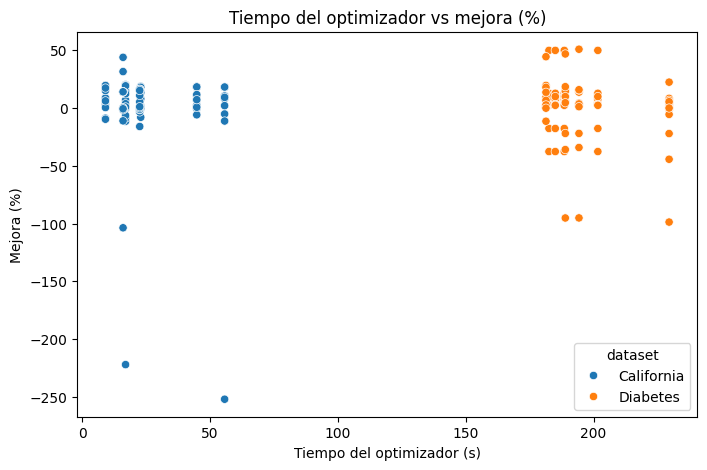

In [24]:
# ---------------------------------------------------------------
# D. Relación entre tiempo de ejecución y mejora obtenida
# ---------------------------------------------------------------
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x="tiempo_optimizador_s", y="mejora_%", hue="dataset")
plt.title("Tiempo del optimizador vs mejora (%)")
plt.xlabel("Tiempo del optimizador (s)")
plt.ylabel("Mejora (%)")
plt.show()

# ---------------------------------------------------------------
# D. Relación entre tiempo de ejecución y mejora obtenida
# ---------------------------------------------------------------
plt.figure(figsize=(8,5))
sns.scatterplot(data=df_hist_plot, x="tiempo_optimizador_s", y="mejora_%", hue="dataset")
plt.title("Tiempo del optimizador vs mejora (%)")
plt.xlabel("Tiempo del optimizador (s)")
plt.ylabel("Mejora (%)")
plt.show()


### Heatmap comparativo de configuraciones y modelos

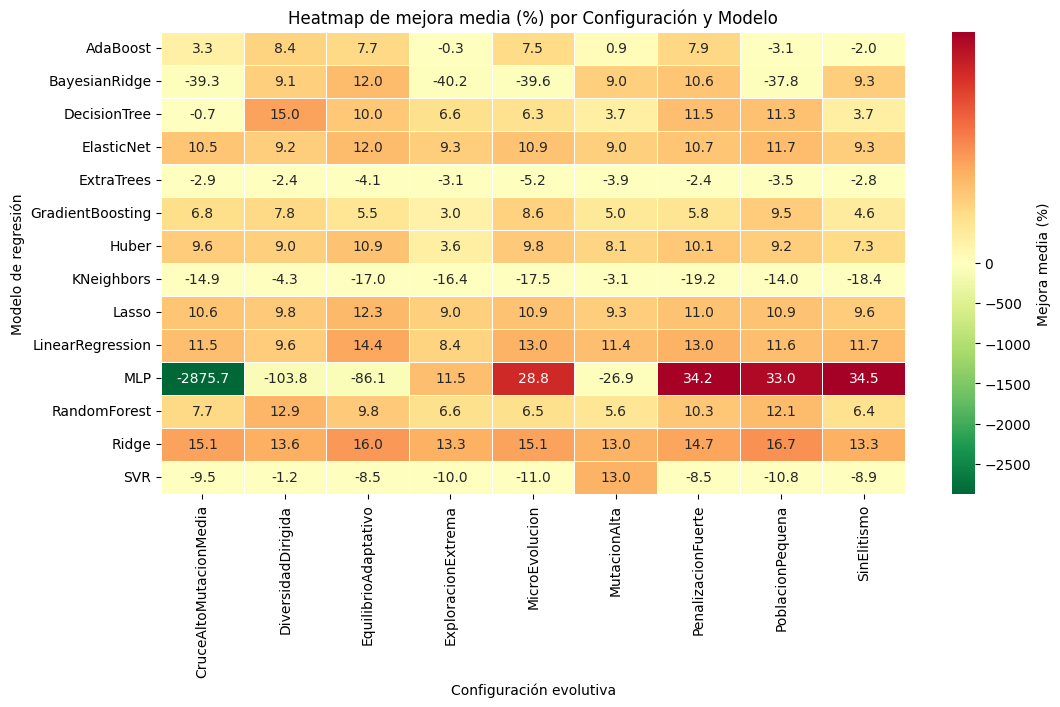

In [27]:
import matplotlib.colors as mcolors

# ---------------------------------------------------------------
# 🔥 Heatmap de mejora media (%) por Configuración y Modelo (divergente real)
# ---------------------------------------------------------------

pivot_cfg_model = df.pivot_table(values="mejora_%", index="modelo", columns="config", aggfunc="mean")

# Calcular límites para normalizar el color (centrado en 0)
vmin = np.nanmin(pivot_cfg_model.values)
vmax = np.nanmax(pivot_cfg_model.values)
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

plt.figure(figsize=(12,6))
sns.heatmap(
    pivot_cfg_model,
    annot=True, fmt=".1f",
    cmap="RdYlGn_r",       # verde para positivo, rojo para negativo
    norm=norm,             # centro de la escala en 0
    linewidths=0.5,
    cbar_kws={"label": "Mejora media (%)"}
)
plt.title("Heatmap de mejora media (%) por Configuración y Modelo")
plt.xlabel("Configuración evolutiva")
plt.ylabel("Modelo de regresión")
plt.show()



### Heatmap comparativo de configuraciones y datasets

### Ranking global de modelos

### Correlaciones entre variables